# **Task 2 : Training a deep learning model that can accurately solve Sudoku puzzles.**

# **Data Preprocessing**
# Loading and Formatting Data:
The data is loaded from CSV files.
The Sudoku puzzles and solutions are extracted from the data and formatted into a suitable structure for training.

In [1]:
import pandas as pd
import numpy as np

def format_sudoku_data(train_images, train_labels):
    num_puzzles = len(train_images) // 81  # Assuming each puzzle has 81 cells
    formatted_data = []

    for i in range(num_puzzles):
        puzzle_str = ''.join(map(str, train_images[i*81:(i+1)*81].astype(int)))
        solution_str = ''.join(map(str, train_labels[i*81:(i+1)*81].astype(int)))
        formatted_data.append([puzzle_str, solution_str])

    return pd.DataFrame(formatted_data, columns=['Quiz', 'Solution'])


train_images = np.loadtxt('/kaggle/input/datatask2-ann/sudoku_predictions_train.csv', delimiter=',', skiprows=1, usecols=1)
train_labels = np.loadtxt('/kaggle/input/datatask2-ann/sudoku_predictions_labels.csv', delimiter=',', skiprows=1, usecols=1)

sudoku_df = format_sudoku_data(train_images, train_labels)
sudoku_df.to_csv('Task2_traindata.csv', index=False)


In [2]:
def format_sudoku_test_data(test_images):
    num_puzzles = len(test_images) // 81  # Assuming each puzzle has 81 cells
    formatted_test_data = []

    for i in range(num_puzzles):
        puzzle_str = ''.join(map(str, test_images[i*81:(i+1)*81].astype(int)))
        formatted_test_data.append(puzzle_str)

    return pd.DataFrame(formatted_test_data, columns=['Quiz'])


test_images = np.loadtxt('/kaggle/input/datatask2-ann/sudoku_predictions_test2.csv', delimiter=',', skiprows=1, usecols=1)

sudoku_test_df = format_sudoku_test_data(test_images)
sudoku_test_df.to_csv('Task2_testdata.csv', index=False)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Load the data
train_data_path = '/kaggle/input/newdata/new_sudoku_dataset.csv' 


In [45]:
train_data_full = pd.read_csv(train_data_path)
print("Full training data loaded. Shape:", train_data_full.shape)

Full training data loaded. Shape: (50000, 2)


In [37]:
train_data_full

,Quiz,Solution
0,0832954170018000590950008620700009000000700203...,6832954174218673597953418625721349868465791233...
1,1007540320002060070048390500010780000405903100...,1697548323582169472748396515314782967465923189...
2,7000508398000230409300782002798004000004970266...,7126548398659237419341782652798614533584971266...
3,0000930078030000290590824039003502016001007081...,2145936878637415297596824139783542616351247481...
4,6507300901986000070370002560003456020000010742...,6527348911986524374371982569713456823852619742...
...,...,...
49995,0896000576200001000408102060107098239020800000...,1896243576279351845438172964167598239724835613...
49996,7413090080050800402300000701000360276570481903...,7413592689657823412386149751895364276572481933...
49997,2004639101040080000800057034200070060008064919...,2574639181347986256892157434219573863758264919...
49998,9082000000024609706748000507000193800000025003...,9382571461524639786748912537256193844693825173...


In [39]:
type(train_data_full['Quiz'][0])

str

In [40]:
len(train_data_full['Quiz'][0])

81

In [41]:
type(train_data_full['Solution'][0])

str

In [42]:
len(train_data_full['Solution'][0])

81

In [43]:
number_of_blanks=[]
for i in range(train_data_full.shape[0]):
    number_of_blanks.append(list(train_data_full['Quiz'][i]).count('0'))
number_of_blanks[:10]

[40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

In [44]:
# Check for the presence of '0' in the "solutions" column
zero_count = train_data_full['Solution'].str.count('0').sum()

# Print the total count of '0's in the "solutions" column
print("Total '0's in solutions:", zero_count)

Total '0's in solutions: 0


In [46]:
train_data = train_data_full.sample(frac=1, random_state=42)
print("Reduced training data shape (100%):", train_data.shape)

Reduced training data shape (100%): (50000, 2)


**Dataset Class:**

A custom Dataset class (CustomSudokuDataset) is implemented for efficient data handling in PyTorch.
This class converts Sudoku strings into tensors suitable for input into a CNN.

In [71]:
class CustomSudokuDataset(Dataset):
    def __init__(self, dataframe, is_train=True):
        self.dataframe = dataframe
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle_str = self.dataframe.iloc[idx, 0]
        puzzle_tensor = torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).view(1, 9, 9) / 9 - 0.5

        if self.is_train:
            solution_str = self.dataframe.iloc[idx, 1]
            # Subtracting 1 from each solution value to match PyTorch's 0-based indexing
            solution_tensor = torch.tensor([int(s) - 1 for s in solution_str], dtype=torch.long).view(81)
            return puzzle_tensor, solution_tensor
        
        return puzzle_tensor


In [72]:
# Create Dataset instances
train_dataset = CustomSudokuDataset(train_data, is_train=True)
print("Train dataset created. Length:", len(train_dataset))

# DataLoader instances
batch_size = 64  # Adjust as necessary
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("Train DataLoader created. Batch size:", batch_size)


Train dataset created. Length: 50000
Train DataLoader created. Batch size: 64


# Model Definition
**CNN Model Architecture:**

The model (SudokuSolver) consists of convolutional layers followed by batch normalization, ReLU activation, and a final fully connected layer.
This architecture is designed to capture spatial relationships in the Sudoku grid.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

class SudokuSolver(nn.Module):
    def __init__(self):
        super(SudokuSolver, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 9 * 9, 81 * 9)
        self.dropout = nn.Dropout(0.5)

    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x.view(-1, 9)  # Reshaped to match [batch_size * 81, 9]

model = SudokuSolver()
print("SudokuSolver model defined.")


SudokuSolver model defined.


In [74]:
# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Loss function and optimizer set.")


Using device: cuda
Loss function and optimizer set.


# Training and Validation
**Data Splitting**:

The training data is randomly split into training and validation sets.
This allows for the evaluation of the model on unseen data.

In [76]:
import random

validation_split = 0.2

random.seed(42)

total_samples = len(train_data)

num_validation_samples = int(validation_split * total_samples)

indices = list(range(total_samples))

random.shuffle(indices)

# Split the indices into training and validation indices
train_indices = indices[num_validation_samples:]
val_indices = indices[:num_validation_samples]

# Create training and validation datasets using the selected indices
train_data_split = train_data[train_indices]
val_data_split = train_data[val_indices]

print("Train data shape:", train_data_split.shape)
print("Validation data shape:", val_data_split.shape)

# Create dataset instances
train_dataset = CustomSudokuDataset(train_data_split, is_train=True)
val_dataset = CustomSudokuDataset(val_data_split, is_train=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Train and validation datasets and loaders created.")

Train data shape: (40000, 2)
Validation data shape: (10000, 2)
Train and validation datasets and loaders created.


**Training Loop:**

The model is trained for a specified number of epochs.
Training involves forward passes, loss computation, and backpropagation.

**Evaluation:**

After each epoch, the model's performance is evaluated on the validation set.
Loss and accuracy metrics are computed to track the learning progress.

In [77]:
num_epochs = 13

def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            optimizer.zero_grad()
            outputs = model(puzzles)
            loss = criterion(outputs, solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == solutions.view(-1)).sum().item()
            total_train += solutions.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)
                outputs = model(puzzles)
                val_loss += criterion(outputs, solutions.view(-1)).item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == solutions.view(-1)).sum().item()
                total_val += solutions.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

Epoch 1/13: Train Loss: 1.7948, Train Accuracy: 24.5578, Validation Loss: 1.1520, Validation Accuracy: 47.9350
Epoch 2/13: Train Loss: 0.9881, Train Accuracy: 51.6809, Validation Loss: 0.6706, Validation Accuracy: 61.4051
Epoch 3/13: Train Loss: 0.7242, Train Accuracy: 59.0011, Validation Loss: 0.5457, Validation Accuracy: 63.9574
Epoch 4/13: Train Loss: 0.6213, Train Accuracy: 61.6199, Validation Loss: 0.4970, Validation Accuracy: 64.7552
Epoch 5/13: Train Loss: 0.5672, Train Accuracy: 63.0440, Validation Loss: 0.4701, Validation Accuracy: 65.2040
Epoch 6/13: Train Loss: 0.5315, Train Accuracy: 64.0083, Validation Loss: 0.4562, Validation Accuracy: 65.3366
Epoch 7/13: Train Loss: 0.5059, Train Accuracy: 64.7129, Validation Loss: 0.4461, Validation Accuracy: 65.4715
Epoch 8/13: Train Loss: 0.4860, Train Accuracy: 65.2717, Validation Loss: 0.4433, Validation Accuracy: 65.4251
Epoch 9/13: Train Loss: 0.4684, Train Accuracy: 65.8257, Validation Loss: 0.4411, Validation Accuracy: 65.4231
E

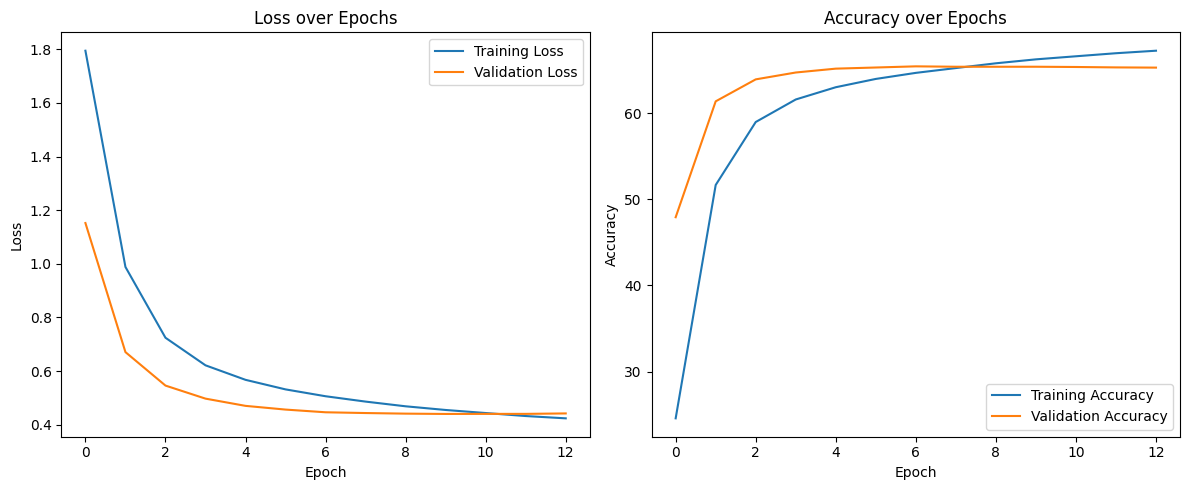

In [78]:
import matplotlib.pyplot as plt

# Train the model and get the metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Testing and Submission

In [79]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Load test data
test_data_path = '/kaggle/working/Task2_testdata.csv'  
test_data = pd.read_csv(test_data_path)

In [80]:
test_data

,Quiz
0,9027008637614000250800000706070950009106000542...
1,0708010200207300001060920040900758800520080038...
2,0009001650806000306012437008070950230307046009...
3,1580096070000760027264183000157040000040800510...
4,0020500096038002059700008361080005032060350800...
...,...
9995,0001050300407062100009405607510943060202507040...
9996,1058000404001300056030509170006005315060030092...
9997,0000278000703000900484500367800000040524009783...
9998,0020950000391800001050020980017200803275009164...


In [81]:
# Create a Dataset for the test data
class TestSudokuDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle_str = self.dataframe.iloc[idx, 0]
        # Normalize the puzzle data
        puzzle_tensor = torch.tensor([int(p) for p in puzzle_str], dtype=torch.float32).view(1, 9, 9) / 9 - 0.5
        return puzzle_tensor

test_dataset = TestSudokuDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


**Test Data Prediction:**

The trained model is used to predict solutions for the test Sudoku puzzles.
Predictions are reshaped to match the format of the solution.

In [82]:
def predict_validation_data_cnn(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track gradients
        for puzzles, solutions in val_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            outputs = model(puzzles)
            # Adjust the output to match the solution format
            predicted_solutions = outputs.argmax(dim=1).view(-1, 9, 9) + 1  # Convert to 1-based indexing
            predictions.extend(predicted_solutions.cpu().numpy())
            actuals.extend(solutions.view(-1, 9, 9).cpu().numpy() + 1)  # Convert actuals to 1-9 digits

    return actuals, predictions


**Confusion Matrix:**

A confusion matrix is plotted to visualize the model's performance in terms of correct predictions for each position in the Sudoku grid.


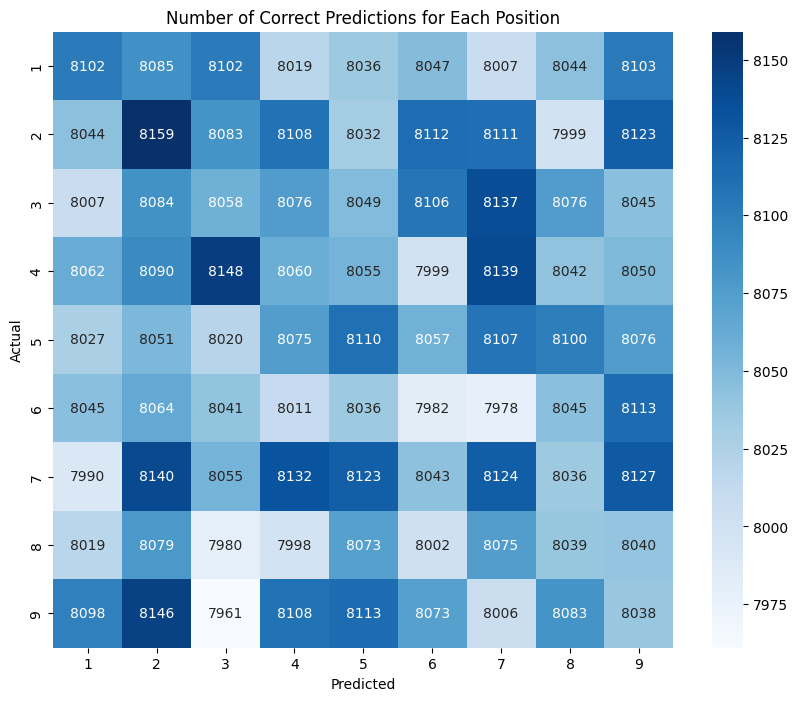

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate predictions on the validation set
actuals, predictions = predict_validation_data_cnn(model, val_loader, device)

# Count correct predictions for each cell
cga = count_grid_acc(actuals, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
ticks = list(range(1, 10))
sns.heatmap(cga, annot=True, fmt='g', cmap='Blues', xticklabels=ticks, yticklabels=ticks)
plt.title('Number of Correct Predictions for Each Position')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Submission File Creation:**

The predictions are compiled into a submission file format as required by the competition.
Each row in the submission file corresponds to a cell in the Sudoku grid with the predicted digit.

In [34]:
def predict_test_data(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for puzzles in test_loader:
            puzzles = puzzles.to(device)
            outputs = model(puzzles)
            # Adjust the output to match the solution format
            predicted_solutions = outputs.argmax(dim=1).view(-1, 9, 9) + 1  # Convert to 1-based indexing
            predictions.extend(predicted_solutions.cpu().numpy())

    return predictions

# Predict on the test dataset
test_predictions = predict_test_data(model, test_loader, device)

# Transform predictions for submission
submission_rows = []
for i, solution in enumerate(test_predictions):
    for row in range(9):
        for col in range(9):
            cell_id = f"{i}_{row}{col}"
            cell_value = solution[row, col]
            submission_rows.append([cell_id, cell_value])

# Create submission DataFrame
submission_df = pd.DataFrame(submission_rows, columns=['id', 'value'])

# Save submission file
submission_df.to_csv('sudoku_submission_2.csv', index=False)


In [36]:
submission_df.head(10)

,id,value
0,0_00,4
1,0_01,4
2,0_02,2
3,0_03,7
4,0_04,5
5,0_05,9
6,0_06,8
7,0_07,6
8,0_08,3
9,0_10,7


Kaggle Result for this approach: **0.80108**

# **Approach 2: Using RNN Model**

# Data Preprocessing
We start by loading and preprocessing our Sudoku dataset. The preprocessing steps include formatting the Sudoku puzzles and solutions, normalizing the data, and preparing it for input into our neural network models.

In [94]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class RNN_SudokuDataset(Dataset):
    def __init__(self, dataframe, is_train=True):
        self.dataframe = dataframe
        self.is_train = is_train

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Flatten the puzzle into a sequence and one-hot encode
        puzzle_str = self.dataframe.iloc[idx, 0]  # Assuming the first column is 'Quiz'
        puzzle_encoded = torch.zeros((81, 10), dtype=torch.float32)  # 81 cells, 10 possible states
        for i, char in enumerate(puzzle_str):
            num = int(char)
            puzzle_encoded[i, num] = 1  # Set the corresponding digit position to 1

        if self.is_train:
            solution_str = self.dataframe.iloc[idx, 1]  # Assuming the second column is 'Solution'
            solution = torch.tensor([int(s) for s in solution_str], dtype=torch.long) - 1  # 0-8 for digits 1-9
            return puzzle_encoded, solution
        
        return puzzle_encoded


# Model Definition
**RNN Model Architecture**

The SudokuRNN model employs a recurrent neural network (RNN) architecture, specifically using Long Short-Term Memory (LSTM) units. This design is particularly effective for processing sequential data, making it well-suited for solving Sudoku puzzles represented as sequences.

In [95]:
import torch.nn as nn
import torch.nn.functional as F

class SudokuRNN(nn.Module):
    def __init__(self):
        super(SudokuRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=10,  # Because we have 10 possible inputs (0-9, one-hot encoded)
                            hidden_size=128,  # Number of features in the hidden state
                            num_layers=2,  # Number of stacked LSTM layers
                            batch_first=True,  # Input and output tensors are provided as (batch, seq, feature)
                            dropout=0.5)  # Dropout for regularization
        self.fc = nn.Linear(128, 9)  # Output layer, 9 classes for digits 1-9

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Fully connected layer to predict each digit
        out = self.fc(lstm_out.reshape(-1, 128))  # Reshape to [batch_size * 81, 128]
        return F.log_softmax(out, dim=1).view(-1, 81, 9)  # Reshape back to [batch_size, 81 (cells), 9 (digit predictions)]


In [96]:
model = SudokuRNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SudokuRNN(
  (lstm): LSTM(10, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate as needed


In [98]:
# Create Dataset instances
train_dataset = RNN_SudokuDataset(train_data, is_train=True)
print("Train dataset created. Length:", len(train_dataset))

# DataLoader instances
batch_size = 64  # Adjust as necessary
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("Train DataLoader created. Batch size:", batch_size)

Train dataset created. Length: 50000
Train DataLoader created. Batch size: 64


# Training and Validation
**Data Splitting**:

The training data is randomly split into training and validation sets.
This allows for the evaluation of the model on unseen data.

In [99]:
import random

validation_split = 0.2

random.seed(42)

total_samples = len(train_data)

num_validation_samples = int(validation_split * total_samples)

indices = list(range(total_samples))

random.shuffle(indices)

# Split the indices into training and validation indices
train_indices = indices[num_validation_samples:]
val_indices = indices[:num_validation_samples]

# Create training and validation datasets using the selected indices
train_data_split = train_data[train_indices]
val_data_split = train_data[val_indices]

print("Train data shape:", train_data_split.shape)
print("Validation data shape:", val_data_split.shape)

# Create dataset instances
train_dataset = RNN_SudokuDataset(train_data_split, is_train=True)
val_dataset = RNN_SudokuDataset(val_data_split, is_train=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Train and validation datasets and loaders created.")

Train data shape: (40000, 2)
Validation data shape: (10000, 2)
Train and validation datasets and loaders created.


In [101]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

num_epochs=10

def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for puzzles, solutions in train_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)

            optimizer.zero_grad()
            outputs = model(puzzles)
            loss = criterion(outputs.view(-1, 9), solutions.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * puzzles.size(0)
            _, predicted = torch.max(outputs, -1)
            train_correct += (predicted.view(-1) == solutions.view(-1)).sum().item()
            train_total += solutions.numel()

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for puzzles, solutions in val_loader:
                puzzles, solutions = puzzles.to(device), solutions.to(device)

                outputs = model(puzzles)
                loss = criterion(outputs.view(-1, 9), solutions.view(-1))

                val_loss += loss.item() * puzzles.size(0)
                _, predicted = torch.max(outputs, -1)
                val_correct += (predicted.view(-1) == solutions.view(-1)).sum().item()
                val_total += solutions.numel()

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    print('Training and validation complete.')

    # Plotting training and validation losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10: Train Loss: 0.0146, Train Accuracy: 0.5554, Validation Loss: 0.0128, Validation Accuracy: 0.5899
Epoch 2/10: Train Loss: 0.0123, Train Accuracy: 0.5927, Validation Loss: 0.0119, Validation Accuracy: 0.5988
Epoch 3/10: Train Loss: 0.0119, Train Accuracy: 0.6015, Validation Loss: 0.0117, Validation Accuracy: 0.6045
Epoch 4/10: Train Loss: 0.0118, Train Accuracy: 0.6046, Validation Loss: 0.0116, Validation Accuracy: 0.6067
Epoch 5/10: Train Loss: 0.0116, Train Accuracy: 0.6085, Validation Loss: 0.0116, Validation Accuracy: 0.6101
Epoch 6/10: Train Loss: 0.0116, Train Accuracy: 0.6107, Validation Loss: 0.0115, Validation Accuracy: 0.6118
Epoch 7/10: Train Loss: 0.0115, Train Accuracy: 0.6127, Validation Loss: 0.0115, Validation Accuracy: 0.6132
Epoch 8/10: Train Loss: 0.0115, Train Accuracy: 0.6140, Validation Loss: 0.0114, Validation Accuracy: 0.6145
Epoch 9/10: Train Loss: 0.0114, Train Accuracy: 0.6158, Validation Loss: 0.0114, Validation Accuracy: 0.6164
Epoch 10/10: Train 

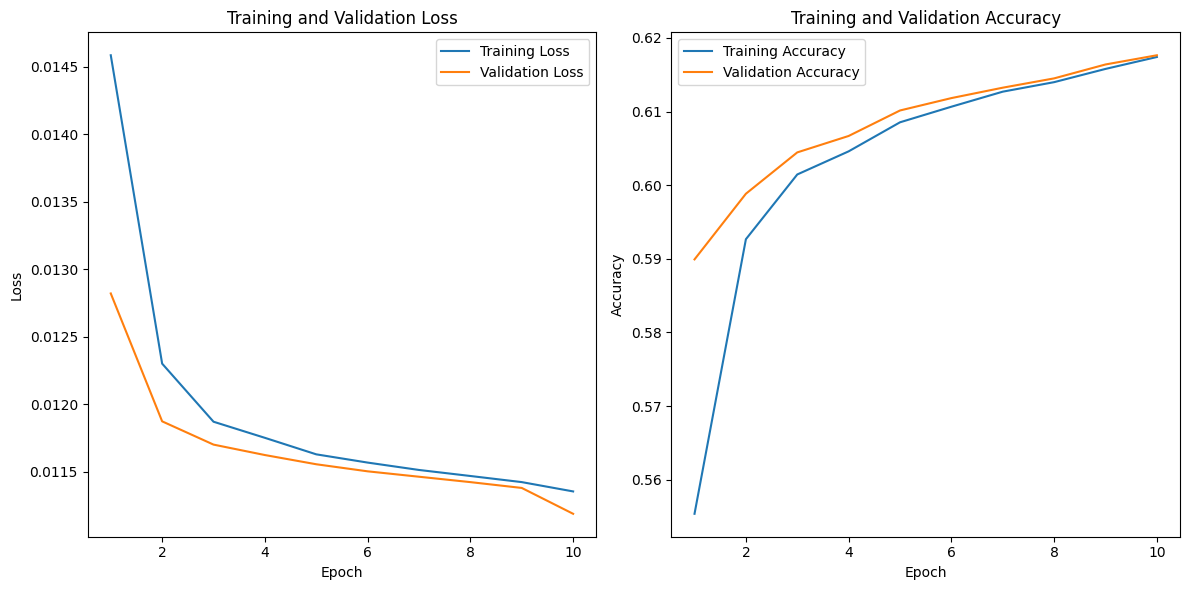

In [102]:
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

# Testing and Submission

In [103]:
class RNN_TestSudokuDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        puzzle_str = self.dataframe.iloc[idx, 0]  # Assuming the first column contains the puzzles
        puzzle_encoded = torch.zeros((81, 10), dtype=torch.float32)  # 81 cells, 10 possible states (one-hot)
        for i, char in enumerate(puzzle_str):
            num = int(char)
            puzzle_encoded[i, num] = 1  # Set the corresponding digit position to 1
        
        return puzzle_encoded


In [104]:
test_data_path = '/kaggle/input/data-task2-ann/Task2_testdata.csv'  # Update this path
test_data = pd.read_csv(test_data_path)

test_dataset = RNN_TestSudokuDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Adjust batch_size as needed


In [105]:
def predict_validation_data(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track gradients
        for puzzles, solutions in val_loader:
            puzzles, solutions = puzzles.to(device), solutions.to(device)
            outputs = model(puzzles)
            _, predicted = torch.max(outputs, -1)
            predictions.extend(predicted.view(-1, 9, 9).cpu().numpy() + 1)  # Reshape and convert to 1-9 digits
            actuals.extend(solutions.view(-1, 9, 9).cpu().numpy() + 1)  # Reshape and convert to 1-9 digits

    return actuals, predictions


**Confusion Matrix:**

A confusion matrix is plotted to visualize the model's performance in terms of correct predictions for each position in the Sudoku grid.


In [106]:
def count_grid_acc(actual, predicted):
    result = np.zeros((9, 9), dtype=int)
    for i in range(len(actual)):
        for j in range(9):
            for k in range(9):
                if actual[i][j][k] == predicted[i][j][k]:
                    result[j][k] += 1
    return result


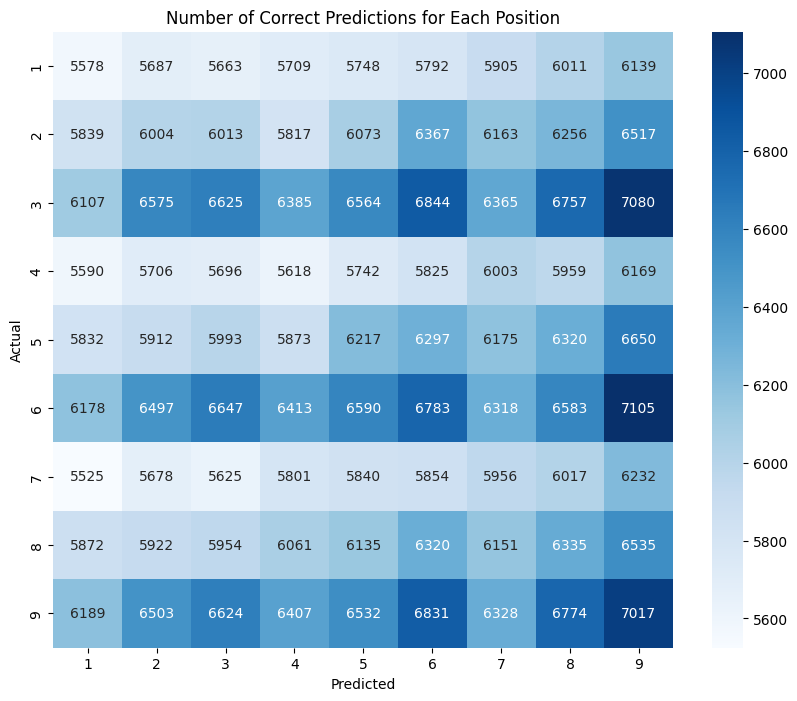

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have actuals and predictions from the validation set
actuals, predictions = predict_validation_data(model, val_loader, device)
cga = count_grid_acc(actuals, predictions)

plt.figure(figsize=(10, 8))
ticks = list(range(1, 10))
sns.heatmap(cga, annot=True, fmt='g', cmap='Blues', xticklabels=ticks, yticklabels=ticks)
plt.title('Number of Correct Predictions for Each Position')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Submission File Creation:**

The predictions are compiled into a submission file format as required by the competition.
Each row in the submission file corresponds to a cell in the Sudoku grid with the predicted digit.

In [108]:
def predict_test_data(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients
        for puzzles in test_loader:
            puzzles = puzzles.to(device)
            outputs = model(puzzles)
            _, predicted = torch.max(outputs, -1)
            predicted = predicted.view(-1, 9, 9) + 1  # Ensure it's reshaped to [batch_size, 9, 9]
            predictions.extend(predicted.cpu().numpy())

    return predictions


In [66]:
def format_predictions_for_submission(predictions):
    submission_rows = []

    for i, puzzle in enumerate(predictions):
        for row in range(9):
            for col in range(9):
                cell_id = f"{i}_{row}{col}"
                cell_value = puzzle[row, col]  # Access the cell value in the 2D puzzle array
                submission_rows.append([cell_id, cell_value])

    submission_df = pd.DataFrame(submission_rows, columns=['id', 'value'])
    return submission_df


In [67]:
def save_submission(submission_df, file_name='sudoku_submission_rnn.csv'):
    submission_df.to_csv(file_name, index=False)
    print(f'Submission saved to {file_name}')


In [68]:
# Generate predictions
test_predictions = predict_test_data(model, test_loader, device)

# Format predictions for submission
submission_df = format_predictions_for_submission(test_predictions)

# Save submission file
save_submission(submission_df, 'sudoku_submission_rnn.csv')


Submission saved to sudoku_submission_rnn.csv


In [69]:
submission_df.head(10)

,id,value
0,0_00,9
1,0_01,8
2,0_02,2
3,0_03,7
4,0_04,6
5,0_05,8
6,0_06,8
7,0_07,6
8,0_08,3
9,0_10,7
